In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting letterEMNIST/EMNIST/raw/gzip.zip to letterEMNIST/EMNIST/raw
Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [4]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


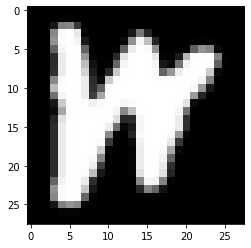

In [5]:
# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

## Create the CNN

In [6]:
# inputs are 28x28

class letterMLP(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [7]:
model = letterMLP(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [8]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [9]:
train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.93108
   Val loss: 1.23702

EPOCH 1
 Train loss: 1.12861
   Val loss: 1.05253

EPOCH 2
 Train loss: 1.01017
   Val loss: 0.97499

EPOCH 3
 Train loss: 0.93474
   Val loss: 0.90611

EPOCH 4
 Train loss: 0.87043
   Val loss: 0.84412

EPOCH 5
 Train loss: 0.80996
   Val loss: 0.78800

EPOCH 6
 Train loss: 0.75483
   Val loss: 0.74014

EPOCH 7
 Train loss: 0.70448
   Val loss: 0.68746

EPOCH 8
 Train loss: 0.65957
   Val loss: 0.64999

EPOCH 9
 Train loss: 0.62029
   Val loss: 0.61886



Test accuracy: 81.615


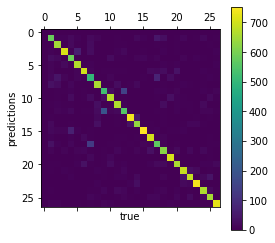

In [10]:
acc, true, pred = test_network(model, test_loader)
print('Test accuracy: %0.3f' % acc)

contingency = np.zeros((len(model.classes), len(model.classes)))
for i in range(len(pred)):
    contingency[int(pred[i])][int(true[i])] += 1

plt.matshow(contingency)
plt.xlabel("true")
plt.ylabel("predictions")
plt.colorbar()

## Visualizing Optimized Inputs

In [17]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [24]:
# Train OptimizeInput model, one for each letter
targets = torch.arange(len(model.classes)).long()
optimized_inputs = []

n_epochs = 10000

for t in targets:
    input_model = OptimizeInput(model)
    optimizer = torch.optim.Adam(input_model.parameters(), lr=.0001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = input_model()
        loss = criterion(outputs, t.reshape(1))
        loss.backward()
        optimizer.step()
    print("finished %s with %0.5f loss" % (model.classes[t], loss.item()))
    optimized_inputs.append(input_model.optimized_input.detach().numpy().reshape((28, 28)))

finished N/A with 3.03184 loss
finished a with 0.00216 loss
finished b with 0.00142 loss
finished c with 0.00112 loss
finished d with 0.00128 loss
finished e with 0.00272 loss
finished f with 0.00080 loss
finished g with 0.00213 loss
finished h with 0.00089 loss
finished i with 0.00159 loss
finished j with 0.00028 loss
finished k with 0.00096 loss
finished l with 0.00040 loss
finished m with 0.00185 loss
finished n with 0.00201 loss
finished o with 0.00407 loss
finished p with 0.00109 loss
finished q with 0.00141 loss
finished r with 0.00184 loss
finished s with 0.00102 loss
finished t with 0.00053 loss
finished u with 0.00170 loss
finished v with 0.00159 loss
finished w with 0.00119 loss
finished x with 0.00165 loss
finished y with 0.00051 loss
finished z with 0.00088 loss


In [25]:
for i in range(len(model.classes)):
    letter = model.classes[i]
    tensor = torch.Tensor(optimized_inputs[i].reshape(1, 1, 28, 28))
    output = model(tensor)
    prob = output.squeeze().detach().numpy()
    pred = model.classes[torch.argmax(output, dim=1)]
    print(f"Expected: {letter}. Predicted: {pred}.")
    
#     plt.figure()
#     plt.bar(range(len(model.classes)), np.exp(prob) / np.exp(prob).sum())
#     plt.xticks(range(len(model.classes)), model.classes)

Expected: N/A. Predicted: j.
Expected: a. Predicted: a.
Expected: b. Predicted: b.
Expected: c. Predicted: c.
Expected: d. Predicted: d.
Expected: e. Predicted: e.
Expected: f. Predicted: f.
Expected: g. Predicted: g.
Expected: h. Predicted: h.
Expected: i. Predicted: i.
Expected: j. Predicted: j.
Expected: k. Predicted: k.
Expected: l. Predicted: l.
Expected: m. Predicted: m.
Expected: n. Predicted: n.
Expected: o. Predicted: o.
Expected: p. Predicted: p.
Expected: q. Predicted: q.
Expected: r. Predicted: r.
Expected: s. Predicted: s.
Expected: t. Predicted: t.
Expected: u. Predicted: u.
Expected: v. Predicted: v.
Expected: w. Predicted: w.
Expected: x. Predicted: x.
Expected: y. Predicted: y.
Expected: z. Predicted: z.


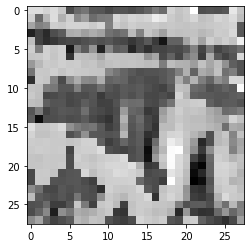

In [42]:
letter = 'j'
letter_visualized = optimized_inputs[model.classes.index(letter)].T
plt.imshow(letter_visualized, cmap='Greys_r')
# letter_visualized = letter_visualized.flatten()
# for i in range(28*28):
#     letter_visualized[i] = 0 if letter_visualized[i] < 0 else 1  
# plt.imshow(letter_visualized.reshape((28,28)), cmap='Greys_r')